# Analisi minimi, massimi, media e deviazione standard

In [ ]:
import pandas as pd
import os

In [ ]:
dataset_path = os.path.join("Dataset", "dataset.csv")
df = pd.read_csv(dataset_path)

In [40]:
df.head()

,Time,Timestamp,Year,Month,Day,Hour,Minute,Second,P_HeatPump,P_CabinePower_L1,...,P L3 WS Light,P WS Light,P L1 WS FanCoil,P L2 WS FanCoil,P L3 WS FanCoil,P WS FanCoil,P L1 WS FM,P L2 WS FM,P L3 WS FM,P WS FM
0,2021-06-01 00:00:11,1.622498e+09,2021,6,1,0,0,11,274.367,83.699,...,310.0,880.0,0.0,0.0,0.0,0.0,440.0,450.0,180.0,1070.0
1,2021-06-01 00:00:26,1.622498e+09,2021,6,1,0,0,26,232.105,84.916,...,310.0,870.0,0.0,0.0,0.0,0.0,450.0,470.0,180.0,1090.0
2,2021-06-01 00:00:41,1.622498e+09,2021,6,1,0,0,41,231.975,84.522,...,310.0,880.0,0.0,0.0,0.0,0.0,410.0,450.0,180.0,1040.0
3,2021-06-01 00:00:56,1.622498e+09,2021,6,1,0,0,56,32.709,84.842,...,310.0,880.0,0.0,0.0,0.0,0.0,540.0,450.0,190.0,1180.0
4,2021-06-01 00:01:11,1.622498e+09,2021,6,1,0,1,11,10.366,83.272,...,310.0,890.0,0.0,0.0,0.0,0.0,430.0,470.0,190.0,1090.0


In [42]:
list_of_field = [
    #"Time", "Timestamp", "Year", "Month", "Day", "Hour", "Minute", "Second",
    #"PL1 React1", "PL2 React2", "PL3 React3", 
    "P_HeatPump", 
    #"P_Cabine", 
    "P_CabinePower_L1", 
    "P_CabineLight_L3", 
    #"P_M2", 
    #"P L1 WS Emergency Light", "P L2 WS Emergency Light", "P L3 WS Emergency Light", 
    "P WS Emergency Light", 
    #"P L1 WS Light", "P L2 WS Light", "P L3 WS Light", 
    "P WS Light", 
    #"P L1 WS FanCoil", "P L2 WS FanCoil", "P L3 WS FanCoil", 
    "P WS FanCoil", 
    #"P L1 WS FM", "P L2 WS FM", "P L3 WS FM", 
    "P WS FM"       
]

rounded_describe = df.describe().round(decimals=2)
rounded_describe[list_of_field]

,P_HeatPump,P_CabinePower_L1,P_CabineLight_L3,P WS Emergency Light,P WS Light,P WS FanCoil,P WS FM
count,1924080.00,1924080.00,1924080.00,1924080.00,1924080.00,1924080.00,1924080.00
mean,281.16,83.65,3.32,1752.44,770.69,46.04,2336.71
std,232.15,4.60,2.89,760.80,144.79,75.42,1733.13
min,0.00,-0.06,-4.16,-70320.00,-37010.00,-20.00,-10.00
25%,15.68,82.18,0.00,1200.00,710.00,0.00,1240.00
50%,284.25,83.13,4.94,1500.00,740.00,0.00,1730.00
75%,445.66,84.14,5.64,2090.00,820.00,80.00,2670.00
max,1436.19,175.65,74.67,23660.00,13990.00,3470.00,16740.00


# Plot curve di carico

In [1]:
from scipy.signal import resample
import numpy as np
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os
import pandas as pd
import calendar

In [2]:
color1 = "#c8a2c8" # lilla
color2 = "#6495ed" # blu fiordaliso
color3 = "#93ccea" # blu fiordaliso chiaro
color4 = "#000000" # nero
color5 = "#2271b3" # blu cielo

In [3]:
SECONDS_IN_DAY = 60*60*24
SECONDS_IN_MONTH = 60*60*24*31
SECONDS_IN_YEAR = 60*60*24*31*12

In [4]:
plot_path = os.path.join("Plot", "DistribuzioneCarichi")
dataset_path = os.path.join("Dataset", "dummy_dataset.csv")

In [5]:
counter = 0
def make_path(base_path, file_name):
    global counter
    counter += 1
    file_name = str(counter) + "-" + file_name  
    return os.path.join(base_path, file_name)

In [6]:
df = pd.read_csv(dataset_path)

In [17]:
def get_x_ticks_from_delta(start, end, resampling):
    delta = end - start
    delta_s = delta.total_seconds()
    delta_s += 1
    
    if delta_s <= SECONDS_IN_DAY:
        step = int(delta_s//60//60) + 1
        positions = np.linspace(0,resampling,step)
        dist = positions[1] - positions[0]
        positions = [x + int(dist//2) for x in positions]
        positions = positions[:-1]
        labels = [str(i)+":00" for i in range(0,len(positions))]
        
    elif delta_s <= SECONDS_IN_MONTH:
        step = int(delta_s//60//60//24) + 1
        positions = np.linspace(0,resampling,step)
        dist = positions[1] - positions[0]
        positions = [x + int(dist//2) for x in positions]
        positions = positions[:-1]
        labels = [str(i+1) for i in range(0,len(positions))]
        
    elif delta_s <= SECONDS_IN_YEAR:
        step = int(delta_s//60//60//24//28)
        positions = np.linspace(0,resampling,step)
        dist = positions[1] - positions[0]
        positions = [x + int(dist//2) for x in positions]
        positions = positions[:-1]
        labels = [str(i+1) for i in range(0,len(positions))]
        
    return positions, labels

In [13]:
def plot_load_distribution(data, start, end, resampling, field, c1, c2, title, xlabel, ylabel, dim, plot_path):
        
    df_tmp = data[
        (data["Year"] >= start.year) & (data["Year"] <= end.year) &
        (data["Month"] >= start.month) & (data["Month"] <= end.month) &
        (data["Day"] >= start.day) & (data["Day"] <= end.day) &
        (data["Hour"] >= start.hour) & (data["Hour"] <= end.hour) &
        (data["Minute"] >= start.minute) & (data["Minute"] <= end.minute) &
        (data["Second"] >= start.second) & (data["Second"] <= end.second)
    ]
        
    plt.figure(figsize=dim) 
    plt.grid(color=c2, linestyle="-", linewidth="0.2", axis="y")
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    positions, labels = get_x_ticks_from_delta(start, end, resampling)
    plt.xticks(positions, labels, rotation=45)
    
    yvalue = list(df_tmp[field])
    
    x_resampled = [x for x in range(0,resampling)]
    y_resampled = resample(yvalue, resampling)
    
    plt.plot(x_resampled, y_resampled, color=c1, linewidth="1.5")
    
    file_name = "".join(title.lower()).replace(" ", "_")
    path = make_path(plot_path, file_name)
    plt.savefig(path, bbox_inches='tight', transparent=True)
    plt.show()

### Plot singolo

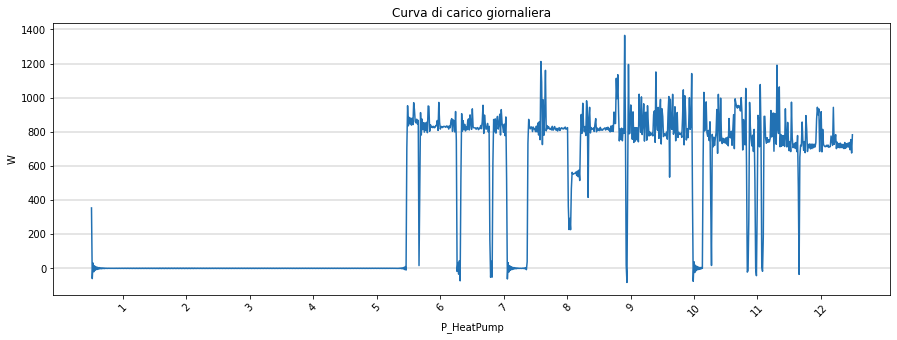

In [30]:
start = datetime(2021, 1, 1, 0, 0, 0)
end = datetime(2021, 12, 31, 23, 59, 59)
resampling = 1000
title = "Curva di carico giornaliera"
xlabel = "P_HeatPump"
ylabel = "W"
dim = (15,5)
plot_load_distribution(df, start, end, resampling, "P WS Light", color5, color4, title, xlabel, ylabel, dim, plot_path)

### Plot multiplo

In [9]:
list_of_field = [
    "P_HeatPump", "P_CabinePower_L1", "P_CabineLight_L3", 
    "P WS Emergency Light", "P WS Light", "P WS FanCoil", "P WS FM"       
]

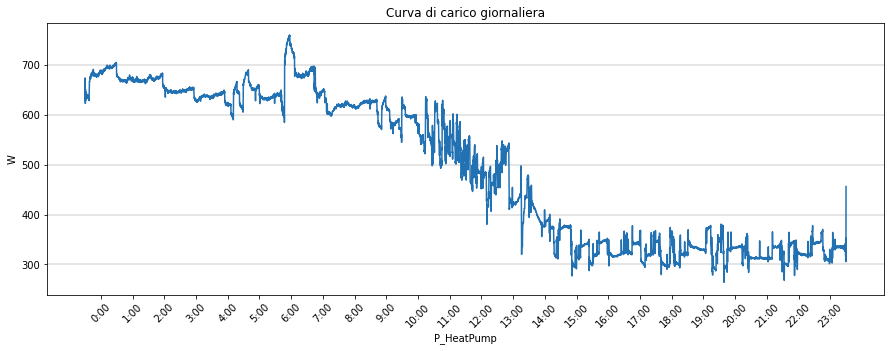

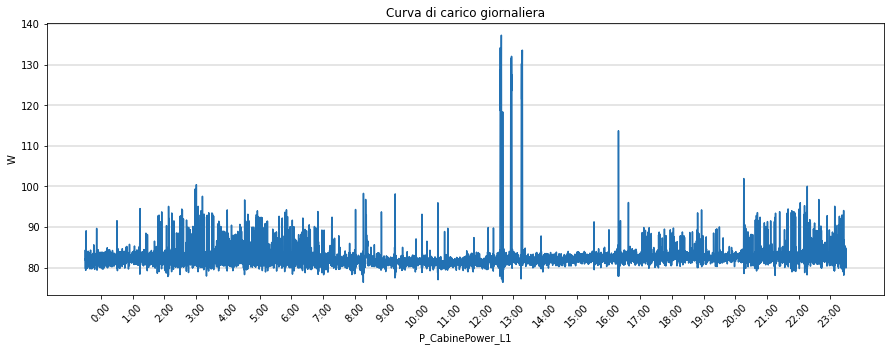

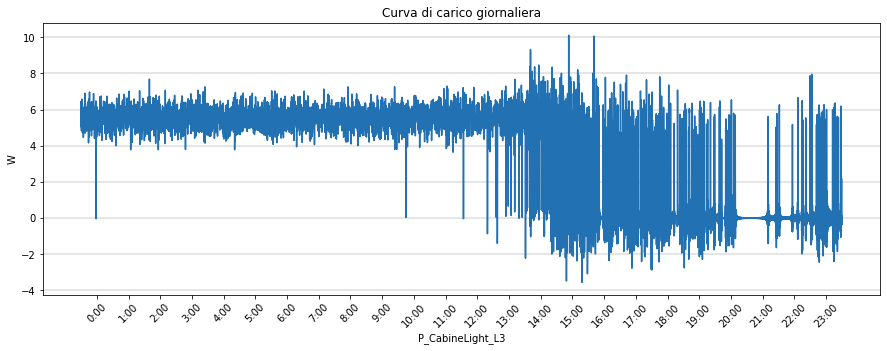

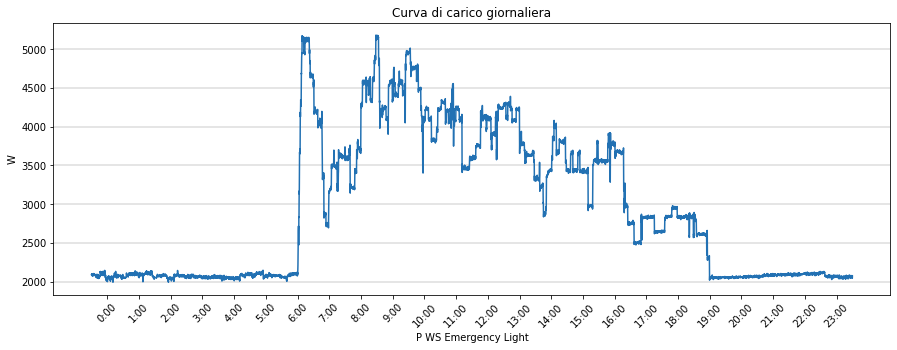

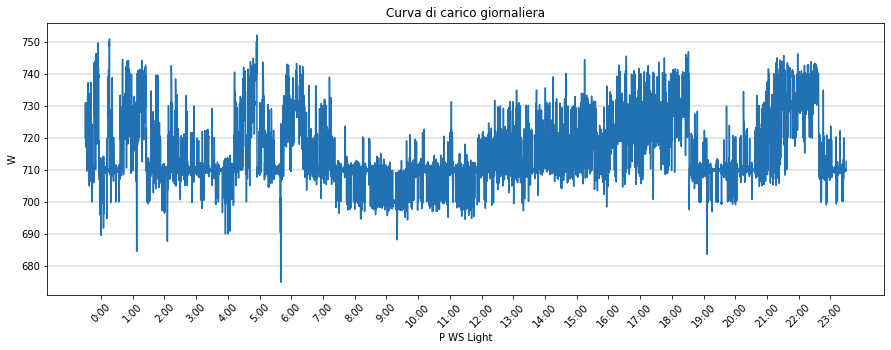

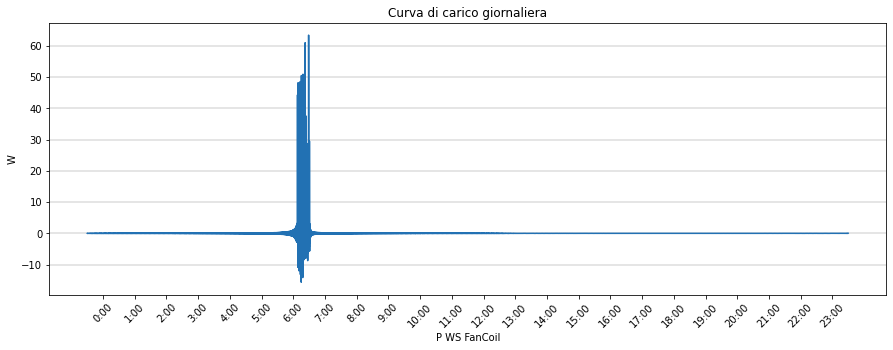

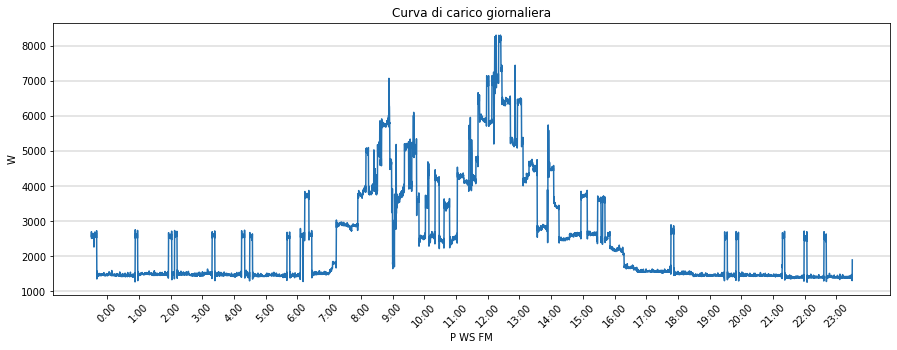

In [20]:
start = datetime(2021, 12, 1, 0, 0, 0)
end = datetime(2021, 12, 1, 23, 59, 59)
resampling = 1000
title = "Curva di carico giornaliera"
ylabel = "W"
dim = (15,5)
for field in list_of_field:
    plot_load_distribution(df, start, end, resampling, field, color5, color4, title, field, ylabel, dim, plot_path)

# Animazione curve di carico

In [ ]:
from scipy.signal import resample
import numpy as np
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os
import pandas as pd
import calendar

In [ ]:
plot_path = os.path.join("Plot", "DistribuzioneCarichi")
dataset_path = os.path.join("Dataset", "dummy_dataset.csv")

In [ ]:
df = pd.read_csv(dataset_path)

In [ ]:
def get_data(data, start, end, resampling, field):
    df_tmp = data[
        (data["Year"] >= start.year) & (data["Year"] <= end.year) &
        (data["Month"] >= start.month) & (data["Month"] <= end.month) &
        (data["Day"] >= start.day) & (data["Day"] <= end.day) &
        (data["Hour"] >= start.hour) & (data["Hour"] <= end.hour) &
        (data["Minute"] >= start.minute) & (data["Minute"] <= end.minute) &
        (data["Second"] >= start.second) & (data["Second"] <= end.second)
    ]
    
    positions, labels = get_x_ticks_from_delta(start, end, resampling)
    
    yvalue = list(df_tmp[field])
    
    x_resampled = [x for x in range(0,resampling)]
    if len(yvalue) >= resampling:
        y_resampled = resample(yvalue, resampling)
    else:
        y_resampled = [0]*resampling
    
    return x_resampled, y_resampled

In [ ]:
SECONDS_IN_DAY = 60*60*24
SECONDS_IN_MONTH = 60*60*24*31
SECONDS_IN_YEAR = 60*60*24*31*12

In [ ]:
def get_x_ticks_from_delta(start, end, resampling):
    delta = end - start
    delta_s = delta.total_seconds()
    delta_s += 1
    
    if delta_s <= SECONDS_IN_DAY:
        step = int(delta_s//60//60) + 1
        positions = np.linspace(0,resampling,step)
        dist = positions[1] - positions[0]
        positions = [x + int(dist//2) for x in positions]
        positions = positions[:-1]
        labels = [str(i)+":00" for i in range(0,len(positions))]
        
    elif delta_s <= SECONDS_IN_MONTH:
        step = int(delta_s//60//60//24) + 1
        positions = np.linspace(0,resampling,step)
        dist = positions[1] - positions[0]
        positions = [x + int(dist//2) for x in positions]
        positions = positions[:-1]
        labels = [str(i+1) for i in range(0,len(positions))]
        
    elif delta_s <= SECONDS_IN_YEAR:
        step = int(delta_s//60//60//24//28) + 1
        positions = np.linspace(0,resampling,step)
        dist = positions[1] - positions[0]
        positions = [x + int(dist//2) for x in positions]
        positions = positions[:-1]
        labels = [str(i+1) for i in range(0,len(positions))]
        
    return positions, labels

In [ ]:
def plot_animation(data, start, end, resampling, field):
    x_min = np.inf
    x_max = -np.inf
    y_min = np.inf
    y_max = -np.inf
    frames = []
    x_ticks_positions = []
    x_ticks_labels = []
    
    delta = end - start
    delta_s = delta.total_seconds()
    delta_s += 1
    
    sstart = []
    eend = []
    if delta_s <= SECONDS_IN_MONTH:
        for i in range(1,calendar.monthrange(start.year, start.month)[1]+1):
            sstart.append(datetime(start.year, start.month, i, 0, 0, 0))
            eend.append(datetime(start.year, start.month, i, 23, 59, 59))
    elif delta_s <= SECONDS_IN_YEAR:
        for i in range(1,13):
            sstart.append(datetime(start.year, i, 1, 0, 0, 0))
            eend.append(datetime(start.year, i, calendar.monthrange(start.year, i)[1], 23, 59, 59))
    else:
        for i in range(start.year, end.year+1):
            sstart.append(datetime(i, 1, 1, 0, 0, 0))
            eend.append(datetime(i, 12, 31, 23, 59, 59))
    
    for start, end in zip(sstart, eend):
            
        x, y = get_data(data, start, end, resampling, field)
        
        if delta_s <= SECONDS_IN_MONTH:
            text = "Giorno: " + str(start.day) + " " + calendar.month_name[start.month] + " " + str(start.year)
        elif delta_s <= SECONDS_IN_YEAR:
            text = "Mese: " + calendar.month_name[start.month] + " " + str(start.year)
        else:
            text = "Anno: " + str(start.year)

        frame_layout = go.Layout(title_text=text)
        frame = go.Frame(data=[go.Scatter(x=x, y=y)], layout=frame_layout)

        frames.append(frame)

        positions, labels = get_x_ticks_from_delta(start, end, resampling)
        x_ticks_positions.append(positions)
        x_ticks_labels.append(labels)

        if x_min > min(x) : x_min = min(x)
        if y_min > min(y) : y_min = min(y)
        if x_max < max(x) : x_max = max(x)
        if y_max < max(y) : y_max = max(y)
    
    fig = go.Figure(
        data=[go.Scatter(x=[], y=[], mode="lines", line=dict(width=2, color="#2271b3"))],
        layout=go.Layout(
            xaxis=dict(title=field, range=[x_min, x_max], autorange=False),
            yaxis=dict(title="W", range=[y_min, y_max], autorange=False),
            title="Animazione"
        ),
        frames=frames
    )

    frames = fig.frames
    for i, frame in enumerate(frames):
        frame["layout"]["xaxis"]["tickvals"] = x_ticks_positions[i]
        frame["layout"]["xaxis"]["ticktext"] = x_ticks_labels[i]

    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                showactive=True,
                buttons=[
                    dict(
                        label="Play",
                        method="animate",
                        args=[
                            None, 
                            {
                                "frame": {"duration": 1000, "redraw": True},
                                "fromcurrent": True, 
                                "transition": {"duration": 200}
                            }
                        ]
                    ),
                    dict(
                        label="Pause",
                        method="animate",
                        args=[
                            [None], 
                            {
                                "frame": {"duration": 0, "redraw": False},
                                "mode": "immediate",
                                "transition": {"duration": 0}
                            }
                        ]
                    )
                ]
            )
        ]
    )

    fig.show()

In [ ]:
list_of_field = [
    "P_HeatPump", "P_CabinePower_L1", "P_CabineLight_L3", 
    "P WS Emergency Light", "P WS Light", "P WS FanCoil", "P WS FM"       
]

In [ ]:
resampling = 2000
start = datetime(2021, 6, 1, 0, 0, 0)
end = datetime(2021, 6, 30, 23, 59, 59)
field = "P_HeatPump"
plot_animation(df, start, end, resampling, field)

# BoxPlot

In [ ]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from scipy.signal import resample

In [ ]:
color1 = "#c8a2c8" # lilla
color2 = "#6495ed" # blu fiordaliso
color3 = "#93ccea" # blu fiordaliso chiaro
color4 = "#000000" # nero
color5 = "#2271b3" # blu cielo
palette = ["#FED4CB", "#FFF2CC", "#C8E1FF", "#D5EDF7", "#F5D0C5", "#E2D7FF", "#FAD6A5"]

In [ ]:
plot_path = os.path.join("Plot", "BoxPlot")
dataset_path = os.path.join("Dataset", "dataset.csv")

In [ ]:
counter = 0
def make_path(base_path, file_name):
    global counter
    counter += 1
    file_name = str(counter) + "-" + file_name  
    return os.path.join(base_path, file_name)

In [ ]:
df = pd.read_csv(dataset_path)

In [ ]:
list_of_field = [
    "P_HeatPump", "P_CabinePower_L1", "P_CabineLight_L3", 
    "P WS Emergency Light", "P WS Light", "P WS FanCoil", "P WS FM"       
]

In [ ]:
def plot_boxplot(data, start, end, fields, colors, title, ylabel, dim, plot_path):
    
    df_tmp = data[
        (data["Year"] >= start.year) & (data["Year"] <= end.year) &
        (data["Month"] >= start.month) & (data["Month"] <= end.month) &
        (data["Day"] >= start.day) & (data["Day"] <= end.day) &
        (data["Hour"] >= start.hour) & (data["Hour"] <= end.hour) &
        (data["Minute"] >= start.minute) & (data["Minute"] <= end.minute) &
        (data["Second"] >= start.second) & (data["Second"] <= end.second)
    ]
    
    plt.figure(figsize=dim) 
    
    plt.title(title)
    plt.ylabel(ylabel)
    
    data_for_plot = [df_tmp[item] for item in fields]
    sns.boxplot(data=data_for_plot, palette=colors)
    
    plt.xticks(list(range(0,len(fields))), fields)

    file_name = "".join(title.lower()).replace(" ", "_")
    path = make_path(plot_path, file_name)
    plt.savefig(path, bbox_inches='tight', transparent=True)
    
    plt.show()

In [ ]:
start = datetime(2021, 7, 1, 0, 0, 0)
end = datetime(2021, 7, 31, 23, 59, 59)
fields = ["P WS FanCoil", "P WS FM"]
colors = ["#FED4CB", "#FFF2CC"]
title = "Titolo"
ylabel = "W"
dim = (15,10)
plot_boxplot(df, start, end, fields, colors, title, ylabel, dim, plot_path)

# Istogrammi (occorrenze valori)

In [31]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

In [32]:
color1 = "#c8a2c8" # lilla
color2 = "#6495ed" # blu fiordaliso
color3 = "#93ccea" # blu fiordaliso chiaro
color4 = "#000000" # nero
color5 = "#2271b3" # blu cielo
palette = ["#FED4CB", "#FFF2CC", "#C8E1FF", "#D5EDF7", "#F5D0C5", "#E2D7FF", "#FAD6A5"]

In [33]:
plot_path = os.path.join("Plot", "IstogrammiDistribuzione")
dataset_path = os.path.join("Dataset", "dataset.csv")

In [34]:
counter = 0
def make_path(base_path, file_name):
    global counter
    counter += 1
    file_name = str(counter) + "-" + file_name  
    return os.path.join(base_path, file_name)

In [35]:
df = pd.read_csv(dataset_path)

In [36]:
def get_distribution_dict(data, start, end, field):
    
    df_tmp = data[
        (data["Year"] >= start.year) & (data["Year"] <= end.year) &
        (data["Month"] >= start.month) & (data["Month"] <= end.month) &
        (data["Day"] >= start.day) & (data["Day"] <= end.day) &
        (data["Hour"] >= start.hour) & (data["Hour"] <= end.hour) &
        (data["Minute"] >= start.minute) & (data["Minute"] <= end.minute) &
        (data["Second"] >= start.second) & (data["Second"] <= end.second)
    ]
    
    distribution_dict = {}
    
    for x in df_tmp[field]:
        if x not in distribution_dict.keys():
            distribution_dict[x] = 0
        distribution_dict[x] += 1

    return dict(sorted(distribution_dict.items()))

In [37]:
def plot_distribution(distribution_dict, title, xlabel, ylabel, dim, c1, c2, plot_path):
    plt.figure(figsize=dim)
    plt.grid(color=c2, linestyle='-', linewidth=0.2, axis="y")

    file_name = "".join(title.lower()).replace(" ", "_")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.yscale("log")
    
    x = list(distribution_dict.keys())
    y = list(distribution_dict.values())
    
    plt.fill_between(x, y, color=c1)
    
    min_x, max_x = np.min(x), np.max(x)
    num_ticks = 20
    x_ticks = np.linspace(min_x, max_x, num_ticks)
    plt.xticks(x_ticks, rotation=45)

    plt.savefig(make_path(plot_path, file_name), bbox_inches='tight', transparent=True)
    plt.show()

### Plot singolo

In [ ]:
start = datetime(2021, 1, 1, 0, 0, 0)
end = datetime(2021, 12, 31, 23, 59, 59)
field = "P_HeatPump"
distribution_dict = get_distribution_dict(df, start, end, field)
plot_distribution(distribution_dict, "title", "xlabel", "ylabel", (15,5), color1, color4, plot_path)

### Plot multiplo

In [38]:
list_of_field = [
    "P_HeatPump", "P_CabinePower_L1", "P_CabineLight_L3", 
    "P WS Emergency Light", "P WS Light", "P WS FanCoil", "P WS FM"       
]

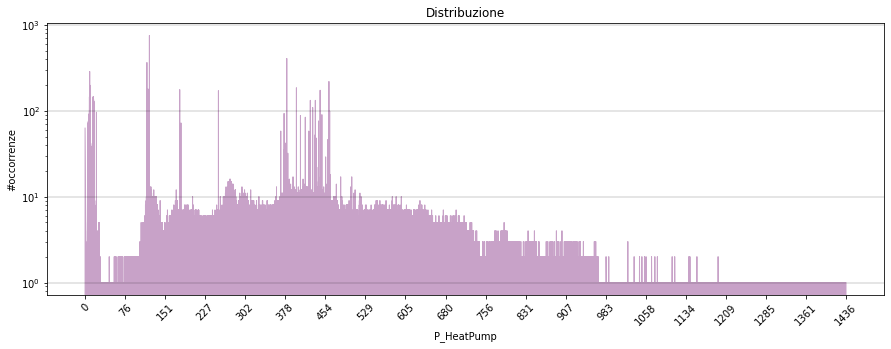

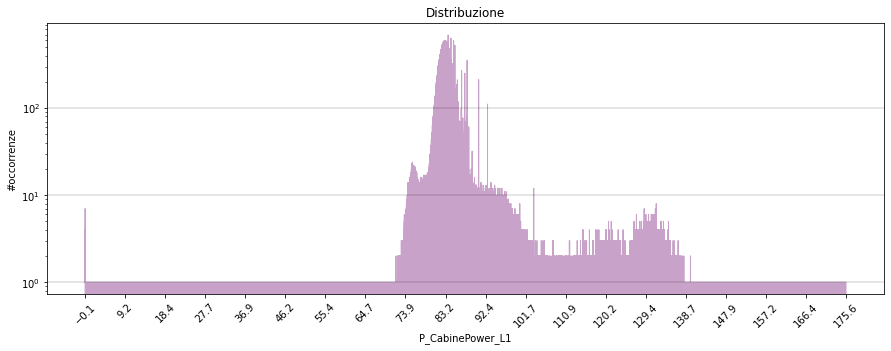

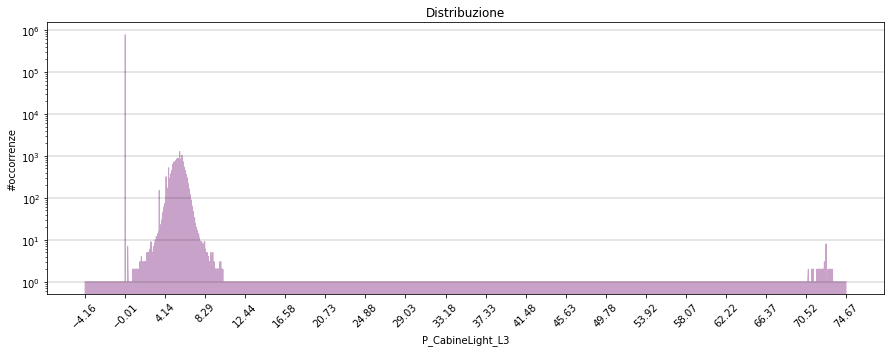

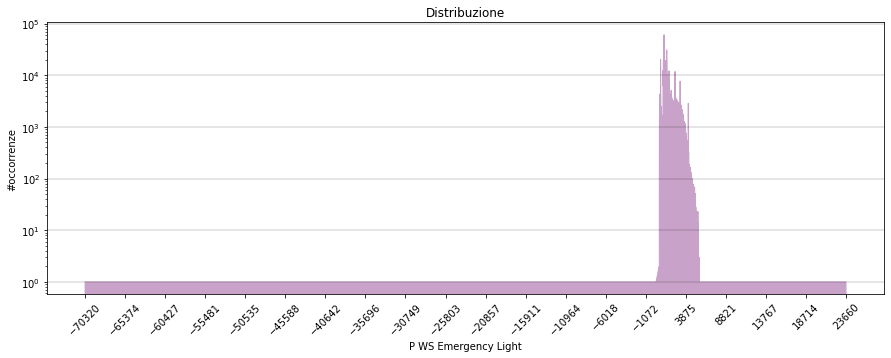

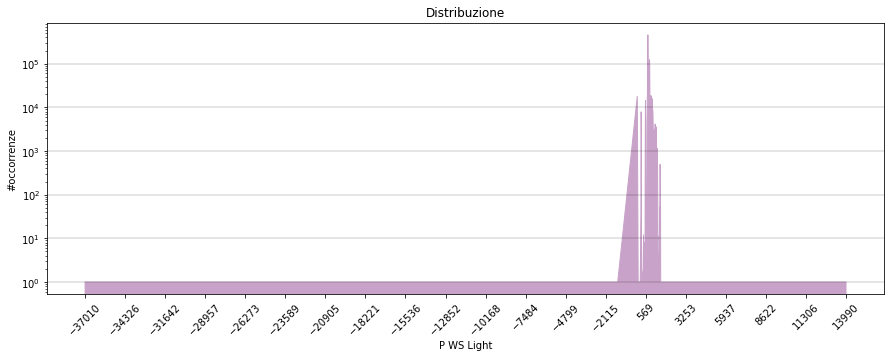

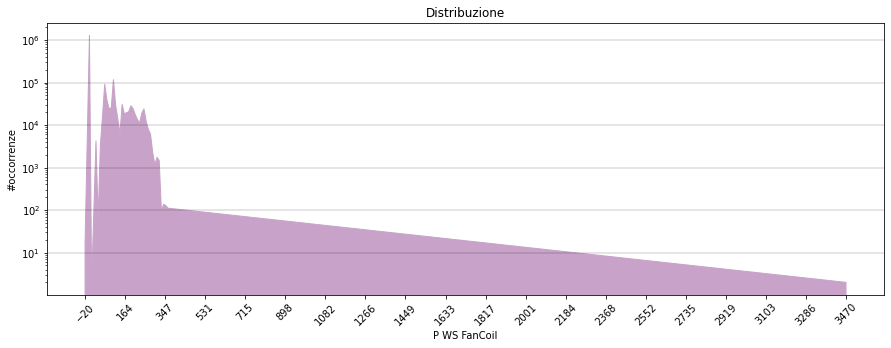

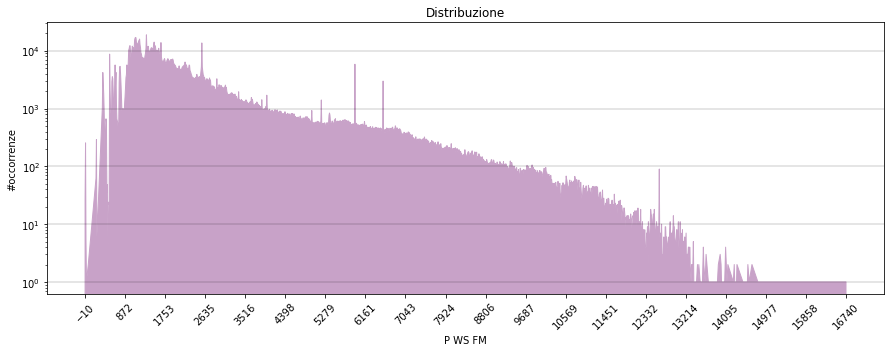

In [39]:
start = datetime(2021, 1, 1, 0, 0, 0)
end = datetime(2022, 12, 31, 23, 59, 59)
for field in list_of_field:
    d = get_distribution_dict(df, start, end, field)
    plot_distribution(d, "Distribuzione", field, "#occorrenze", (15,5), color1, color4, plot_path)